## Convergence of quadrature rules

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.labelsize': 18})
from numpy import *
from scipy import stats
from functools import partial

Exact integral of $x^{d}$ on $[a, b]$:

In [7]:
def I(d, a, b):
    return (b**(d+1) - a**(d+1)) / (d+1)

Closed Newton-Cotes quadrature ($N+1$ uniformly spaced nodes between interval endpoints):

In [8]:
def Qtrap(f, a, b):
    return (b-a)/2 * (f(a) + f(b))

def Qsimpson(f, a, b):
    return (b-a) * ( f(a) + 4.*f((a+b)/2) + f(b) )/ 6.

def Qnewtoncotes(N, f, a, b):  # (Closed) Newton-Cotes of x^d with N+1 nodes on [0,h]
    xx = linspace(a,b,N+1)
    rhs = array([I(d, a, b) for d in range(N+1)])
    V = vander(xx, increasing=True).T
    w = dot(linalg.inv(V), rhs)
    return dot(w, f(xx))

In [9]:
def dop(Q):
    for d in range(100):
        if abs(I(d, 0, 1) - Q(lambda x: x**d, 0, 1)) > 1.e-8:
            break
    return d-1

Accuracy tests:
1. Empirically determine degree-of-precision
2. Measure rate of convergence of error as $h\rightarrow 0$

DoP (Rule1) = 7, conv = 9.000000000001448 ~= 9.0
DoP (Rule2) = 3, conv = 5.0 ~= 5.0


Text(0, 0.5, '$log_{10} \\epsilon$')

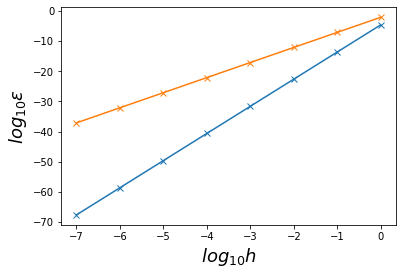

In [14]:
N = 6
Qrule1 = partial(Qnewtoncotes, N)
Qrule2 = Qsimpson

d1 = dop(Qrule1)
d2 = dop(Qrule2)
loghs = array(range(0,-8,-1))
Es1, Es2 = [], []
for logh in loghs:
    Q1 = Qrule1(lambda x: x**(d1+1), 0, 10.**logh)
    I1 = I(d1+1, 0, 10.**logh)
    Q2 = Qrule2(lambda x: x**(d2+1), 0, 10.**logh)
    I2 = I(d2+1, 0, 10.**logh)
    
    Es1.append( log10(abs(Q1 - I1)) ) 
    Es2.append( log10(abs(Q2 - I2)) ) 
    
fit1 = stats.linregress(loghs, Es1)
print(f'DoP (Rule1) = {d1}, conv = {fit1.slope} ~= {round(fit1.slope)}')
fit2 = stats.linregress(loghs, Es2)
print(f'DoP (Rule2) = {d2}, conv = {fit2.slope} ~= {round(fit2.slope)}')

plt.plot(loghs, Es1, 'x-')
plt.plot(loghs, Es2, 'x-')
plt.xlabel(r'$log_{10}h$')
plt.ylabel(r'$log_{10} \epsilon$')

### Composite rule

In [16]:
def Qcomposite(N, M, f, a, b):  # M intervals, 
    xintervals = linspace(a, b, M+1)
    return sum([Qnewtoncotes(N, f, xintervals[i], xintervals[i+1]) 
               for i in range(M)])

In [17]:
a, b = 0,1
def f(x): return x**7 #1./(1+x**2)
def If(): return 1./8 #arctan(b) - arctan(a)

Ns = [1, 2, 3, 4, 5]
logMs = array(range(8))
errors = zeros((len(Ns), len(logMs)))
for iN, N in enumerate(Ns):
    for iM, logM in enumerate(logMs):
        Q = Qcomposite(N, 2**logM, f, a, b)
        errors[iN, iM] = abs(Q - If())

Conv (N=1) = 1.798847862165572 ~= 2.0
Conv (N=2) = 3.800956842204594 ~= 4.0
Conv (N=3) = 3.8278090389272164 ~= 4.0
Conv (N=4) = 5.999821198465886 ~= 6.0
Conv (N=5) = 5.986303909880655 ~= 6.0


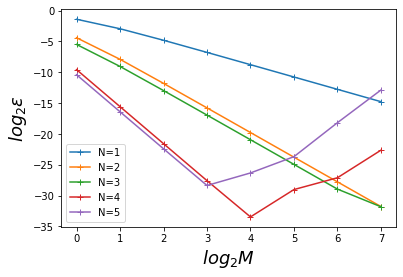

In [19]:
for iN, N in enumerate(Ns):
    plt.plot(logMs, log2(errors[iN,:]), '+-', label=f'N={N}')
    fit = stats.linregress(logMs[:4], log2(errors[iN,:4]))
    print(f'Conv (N={N}) = {-fit.slope} ~= {round(-fit.slope)}')
plt.xlabel(r'$log_2 M$')
plt.ylabel(r'$log_2 \epsilon$')
plt.legend()